# Matías Seda

En esta tarea vas a experimentar con diferentes funciones de activación y su rol en el aprendizaje de redes neuronales. Lo primero que haremos es importar los paquetes importantes para nuestro notebook e inicializar el gpu. Asegúrate que tu notebook se ejecuta sobre un GPU. Si es así, al ejecutar la siguiente celda debería salirte el mensaje "cuda".

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


A continuación hay un conjunto de funciones que puedes usar para hacer tus experimentos. Los detalles de cada función están como comentario antes del código de la función.

In [ ]:
#Esta función permite inicializar todas las semillas de números pseudoaleatorios.
# Puedes usar esta función para resetear los generadores de números aleatorios
def iniciar_semillas():
  SEED = 1234

  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True

#Función para computar el accuracy. Se asume que predicciones y etiquetas son tensores en el GPU
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc

#Función para entrenar una época de un modelo. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -optimizer: el optimizador para el entrenamiento
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def train_one_epoch(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation  
  model.train()
  
  #Training loop
  for (x, y) in iterator:
    x = x.to(device) #Data
    y = y.long().to(device) #Labels
        
    optimizer.zero_grad() #Clean gradients
             
    y_pred = model(x) #Feed the network with data
        
    loss = criterion(y_pred, y) #Compute the loss
       
    acc = calculate_accuracy(y_pred, y) #Compute the accuracy
        
    loss.backward() #Compute gradients
        
    optimizer.step() #Apply update rules
        
    epoch_loss += loss.item()
    epoch_acc += acc.item()
        
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Función que evalúa una red neuronal con un conjunto de datos de prueba. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We put the network in testing mode
  #In this mode, Pytorch doesn't use features only reserved for 
  #training (dropout for instance)    
  model.eval()
    
  with torch.no_grad(): #disable the autograd engine (save computation and memory)
        
    for (x, y) in iterator:
      x = x.to(device)
      y = y.long().to(device)

      y_pred= model(x)

      loss = criterion(y_pred, y)

      acc = calculate_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Calcula el tiempo transcurrido entre dos timestamps
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#Esta función realiza el entrenamiento completo de una red. Recibe como parámetros:
#     -network: la red neuronal
#     -optimizer: el optimizador para entrenamiento
#     -train_loader: el dataloader de datos de entrenamiento
#     -tes_loader: el dataloader de datos de prueba
#     -name: nombre a usar para guardar en disco la red con el mejor accuracy

def train_complete(network, optimizer, train_loader, test_loader, name):
  
  #Se envían la red y la función de loss al GPU
  network = network.to(device)
  criterion = nn.CrossEntropyLoss()
  criterion = criterion.to(device)

  #Fijar el entrenamiento en 20 épocas siempre
  EPOCHS = 10

  best_valid_acc = float('-inf')

  for epoch in range(EPOCHS):
    
    start_time = time.time()

    #Train + validation cycles  
    train_loss, train_acc = train_one_epoch(network, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(network, test_loader, criterion, device)
    
    #Si encontramos un modelo con accuracy de validación mayor, lo guardamos
    if valid_acc > best_valid_acc:
     best_valid_acc = valid_acc
     torch.save(network.state_dict(), f'{name}.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
  
  #Cuando se termina el entrenamiento, cargamos el mejor modelo guardado y calculamos el accuracy de prueba
  network.load_state_dict(torch.load(f'{name}.pt'))

  test_loss , test_acc = evaluate(network, test_loader, criterion, device)
  print(f'Test Loss: {test_loss:.3f} | Mejor test acc: {test_acc*100:.2f}%')

Para nuestros experimentos usaremos el dataset FashionMNIST, que consta de imágenes en escala de grises de 28x28 píxeles que representan prendas de ropa clasificadas en 10 clases. Inicializamos los hiperparámetros y cargamos los conjuntos de datos de entrenamiento y prueba. También se crean los dataloaders correspondientes.

In [ ]:
# Hyper-parameters 
input_size = 784
num_classes = 10
batch_size_train = 1000
batch_size_test = 1000
momentum = 0.9
log_interval = 100
learning_rate=0.005

# MNIST dataset 
train_dataset = torchvision.datasets.FashionMNIST(root='data', 
                    train=True, 
                    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]),  
                    download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='data', 
                                          train=False, 
                                          transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]))


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size_train, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size_test, 
                                          shuffle=False)

class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']


Inspeccionamos algunas muestras del conjunto de datos de prueba

Numero de batch: 0
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


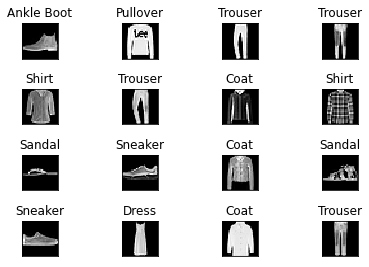

In [ ]:
examples = enumerate(test_loader) #Crea un iterador sobre la lista de batches

batchId, (exampleData, exampleTargets) = next(examples) #Obtenemos el siguiente batch
print('Numero de batch: {}'.format(batchId))
print(exampleData.shape)
print(exampleTargets.shape)

import matplotlib.pyplot as plt

#Mostramos los primeros 6 elementos del batch con su etiqueta
plt.figure()
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.tight_layout()
  plt.imshow(exampleData[i][0], cmap='gray', interpolation='none')
  plt.title(class_names[exampleTargets[i]])
  plt.xticks([])
  plt.yticks([])

# Parte 1 - Creación de red neuronal
Crea una arquitectura de red neuronal (MLP - multilayer perceptron) que reciba datos de 784 dimensiones (recuerda que las imágenes del experimento son de 28x28 = 784 píxeles) y tenga 10 neuronas de salida. Para esta primera red usa la función sigmoide como función de activación en todas las capas ocultas y la función softmax en la capa de salida (recuerda que si usas nn.CrossEntropyLoss, no necesitas aplicar ninguna función adicional a la última capa de la red).

In [ ]:
#Creamos la red neuronal
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
  def __init__(self, layers):
    super(Net, self).__init__()
    # Define aquí las capas de tu red
    self.layers = layers
    
  def forward(self, input):
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    return self.layers(input)
    #Implementa la función forward usando la función de activación sigmoide en las capas ocultas
  


In [ ]:
def get_layers(activation):
  layers = nn.Sequential(
      nn.Linear(784, 12),
      activation(),
      nn.Linear(12, 10),
      )
  return layers

Para ejecutar el entrenamiento de tu primer modelo, ejecuta la siguiente celda y debería reportarte el accuracy de prueba de este primer experimento. Cuánto obtienes de accuracy de test?

In [ ]:
iniciar_semillas() # Se inicializan las semillas

layers = get_layers(nn.Sigmoid)

network = Net(layers) # Creas la red

optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'sigmoid') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 1.610 | Train Acc: 63.09%
	 Val. Loss: 1.220 |  Val. Acc: 74.46%
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 1.009 | Train Acc: 77.66%
	 Val. Loss: 0.865 |  Val. Acc: 78.61%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.763 | Train Acc: 80.80%
	 Val. Loss: 0.710 |  Val. Acc: 80.91%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.641 | Train Acc: 82.58%
	 Val. Loss: 0.629 |  Val. Acc: 81.74%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.572 | Train Acc: 83.57%
	 Val. Loss: 0.574 |  Val. Acc: 82.90%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.526 | Train Acc: 84.15%
	 Val. Loss: 0.541 |  Val. Acc: 82.99%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.490 | Train Acc: 84.83%
	 Val. Loss: 0.515 |  Val. Acc: 83.47%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.467 | Train Acc: 85.09%
	 Val. Loss: 0.496 |  Val. Acc: 83.59%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.449 | Train Acc: 85.33%
	 Val. Loss: 0.490 |  Val. Acc: 83.56%
Epoch: 10 | Epoch T

# Parte 2
En esta parte vas a comparar el accuracy de test de la primera red que creaste (con función de activación sigmoide) y los accuracys obtenidos usando otras funciones de activación. Para lograr esto debes hacer lo siguiente:



*   Implementa exactamente la misma arquitectura que tu primera red, pero ahora vas a usar las siguientes funciones de activación: Leaky Relu, Mish, Elu y Silu. Implementa una clase por cada función de activación, en donde la red neuronal use la misma función de activación en las capas ocultas. Asegúrate que la arquitectura es la misma y que lo único que cambia entre las distintas redes es la función de activación de las capas ocultas.
*   Entrena cada red usando la función "train_complete" usando el mismo optimizador siempre. 
*   Registra los mejores accuracys de test de cada red neuronal.
*   Discute los resultados ontenidos. Puedes tratar de responder a estas preguntas:
    * Qué función de activación dio el mejor accuracy de test?
    * Porqué crees que, ante las mismas condiciones, hay funciones de activación que funcionan mejor que otras?
    * Averigua cómo funcionan cada una de las funciones de activación usadas en la tarea. Es posible hacer algún razonamiento sobre el comportamiento de cada función y que eso permita explicar los resultados de tu tarea?

## Leaky Relu

In [ ]:
iniciar_semillas() # Se inicializan las semillas

layers = get_layers(nn.LeakyReLU)

network = Net(layers) # Creas la red

optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'leaky_relu') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.922 | Train Acc: 66.12%
	 Val. Loss: 0.577 |  Val. Acc: 78.91%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.508 | Train Acc: 82.01%
	 Val. Loss: 0.501 |  Val. Acc: 82.05%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.459 | Train Acc: 83.85%
	 Val. Loss: 0.489 |  Val. Acc: 82.58%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.435 | Train Acc: 84.72%
	 Val. Loss: 0.463 |  Val. Acc: 83.39%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.420 | Train Acc: 85.24%
	 Val. Loss: 0.456 |  Val. Acc: 84.18%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.409 | Train Acc: 85.60%
	 Val. Loss: 0.441 |  Val. Acc: 84.27%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.397 | Train Acc: 86.04%
	 Val. Loss: 0.434 |  Val. Acc: 84.75%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.390 | Train Acc: 86.21%
	 Val. Loss: 0.431 |  Val. Acc: 84.86%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.383 | Train Acc: 86.45%
	 Val. Loss: 0.427 |  Val. Acc: 84.69%
Epoch: 10 | Epoch T

## Mish

In [ ]:
iniciar_semillas() # Se inicializan las semillas

layers = get_layers(nn.Mish)

network = Net(layers) # Creas la red

optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'mish') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.898 | Train Acc: 67.67%
	 Val. Loss: 0.571 |  Val. Acc: 78.99%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.496 | Train Acc: 82.18%
	 Val. Loss: 0.491 |  Val. Acc: 82.47%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.449 | Train Acc: 84.19%
	 Val. Loss: 0.484 |  Val. Acc: 82.79%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.426 | Train Acc: 84.96%
	 Val. Loss: 0.458 |  Val. Acc: 83.69%
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.414 | Train Acc: 85.48%
	 Val. Loss: 0.450 |  Val. Acc: 84.13%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.402 | Train Acc: 85.71%
	 Val. Loss: 0.442 |  Val. Acc: 84.42%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.396 | Train Acc: 86.06%
	 Val. Loss: 0.433 |  Val. Acc: 84.50%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.387 | Train Acc: 86.35%
	 Val. Loss: 0.426 |  Val. Acc: 85.14%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.380 | Train Acc: 86.58%
	 Val. Loss: 0.429 |  Val. Acc: 84.44%
Epoch: 10 | Epoch T

## Elu

In [ ]:
iniciar_semillas() # Se inicializan las semillas

layers = get_layers(nn.ELU)

network = Net(layers) # Creas la red

optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'elu') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.838 | Train Acc: 71.12%
	 Val. Loss: 0.568 |  Val. Acc: 79.37%
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 0.496 | Train Acc: 82.32%
	 Val. Loss: 0.492 |  Val. Acc: 82.76%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.451 | Train Acc: 84.21%
	 Val. Loss: 0.484 |  Val. Acc: 82.99%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.427 | Train Acc: 85.04%
	 Val. Loss: 0.457 |  Val. Acc: 83.69%
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.412 | Train Acc: 85.59%
	 Val. Loss: 0.458 |  Val. Acc: 83.98%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.401 | Train Acc: 85.80%
	 Val. Loss: 0.433 |  Val. Acc: 84.72%
Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 0.390 | Train Acc: 86.29%
	 Val. Loss: 0.428 |  Val. Acc: 84.78%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.382 | Train Acc: 86.47%
	 Val. Loss: 0.422 |  Val. Acc: 85.05%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.376 | Train Acc: 86.77%
	 Val. Loss: 0.418 |  Val. Acc: 85.01%
Epoch: 10 | Epoch T

## Silu

In [ ]:
iniciar_semillas() # Se inicializan las semillas

layers = get_layers(nn.SiLU)

network = Net(layers) # Creas la red

optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'silu') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.884 | Train Acc: 68.22%
	 Val. Loss: 0.563 |  Val. Acc: 79.43%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.488 | Train Acc: 82.54%
	 Val. Loss: 0.493 |  Val. Acc: 82.64%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.445 | Train Acc: 84.18%
	 Val. Loss: 0.477 |  Val. Acc: 82.98%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.420 | Train Acc: 85.13%
	 Val. Loss: 0.452 |  Val. Acc: 83.88%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.407 | Train Acc: 85.77%
	 Val. Loss: 0.446 |  Val. Acc: 84.28%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.397 | Train Acc: 85.92%
	 Val. Loss: 0.440 |  Val. Acc: 84.35%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.391 | Train Acc: 86.16%
	 Val. Loss: 0.429 |  Val. Acc: 84.42%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.382 | Train Acc: 86.49%
	 Val. Loss: 0.425 |  Val. Acc: 85.21%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.375 | Train Acc: 86.81%
	 Val. Loss: 0.424 |  Val. Acc: 84.56%
Epoch: 10 | Epoch T

## Resultados

Inicialmente, realizamos una MLP con la siguiente estructura (en código python):
```python
  layers = nn.Sequential(
      nn.Linear(784, 512),
      activation(),
      nn.Linear(512, 256),
      activation(),
      nn.Linear(256, 128),
      activation(),
      nn.Linear(128, 10),
      )
```
donde `activation()` es una función de activación (por ejemplo, `nn.Sigmoid()`)

Dicha red se entró con 20 épocas y entregó los siguientes resultados:

| Función de activación    | Mejor test acc |    
|--------------------------|----------------|
| Sigmoide                 | 87.94 %        |
| Leaky Relu               | 88.34 %        |
| Mish                     | 88.40 %        |
| Elu                      | 88.42 %        |
| Silu                     | 88.35%         |

Dado que los resultados fueron muy cercanos, se pensó que, tal vez, implementar una red más simple y con menos épocas podría permitir obserar mayores diferencias. En ese sentido, se creo una MLP con la siguiente estructura (en código python).
```python
  layers = nn.Sequential(
      nn.Linear(784, 12),
      activation(),
      nn.Linear(12, 10),
      )
```
Dicha red se entrenó con solo 10 épocas y entregó los siguientes resultados:

| Función de activación    | Mejor test acc |    
|--------------------------|----------------|
| Sigmoide                 | 83.89 %        |
| Leaky Relu               | 84.86 %        |
| Mish                     | 85.14 %        |
| Elu                      | 85.05 %        |
| Silu                     | 85.21%         |

En este caso, los resultados también fueron bastantes cercanos pero se observó una mayor diferencia entre los valores obtenidos. Más en particular, se vislumbró una mayor diferencia entre la función de activación "Sigmoide" y las otras funciones.

## Análisis resultados

Inicialmente, para realizar un análisis más completo de las pequeñas diferencias encontradas en las distintas redes con sus respectivas funciones de activación, se desarrolló distintos códigos para calcular y graficar dichas funciones y sus derivadas.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_activation_deri(act, deri, title):
  x = np.arange(-5,5,0.001)
  y_act = act(x)
  y_deri = deri(x)

  plt.figure(figsize=(14,10))
  plt.plot(x, y_act, color='b', label="Función activación")
  plt.plot(x, y_deri, color='r', label="Derivada")

  plt.xlabel("X", fontsize=20)
  plt.ylabel("Y", fontsize=20)
  plt.title(title,fontsize=20)
  plt.legend(fontsize=20)
  plt.grid()
  plt.show()

### Gráficos funciones de activación y sus derivadas.



# **Función Sigmoide**

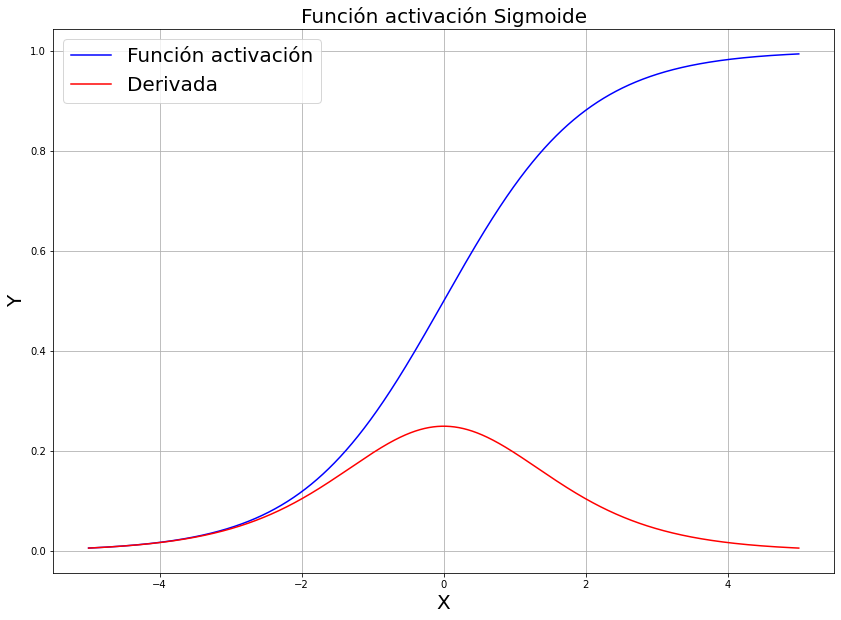

In [ ]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))

def deri_sigmoid(x):
  return sigmoid(x)*(1-sigmoid(x))

plot_activation_deri(sigmoid, deri_sigmoid, "Función activación Sigmoide")



# **Función Leaky ReLU**

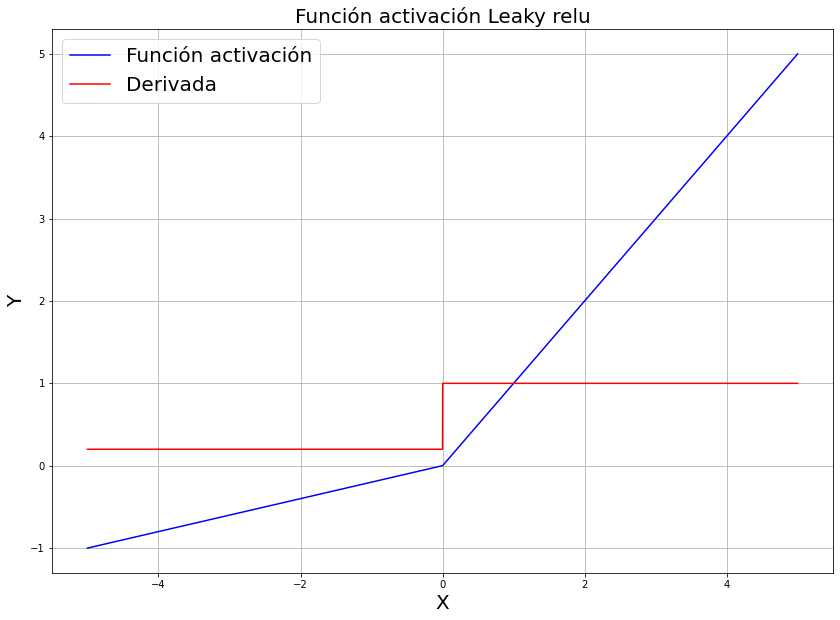

In [ ]:
def leaky_relu(x):
  return list(map(lambda x: x if x>0 else x*0.2, x))

def deri_leaky_relu(x):
  return list(map(lambda x: 1 if x>0 else 0.2, x))

plot_activation_deri(leaky_relu, deri_leaky_relu, "Función activación Leaky relu")

# **Función Mish**

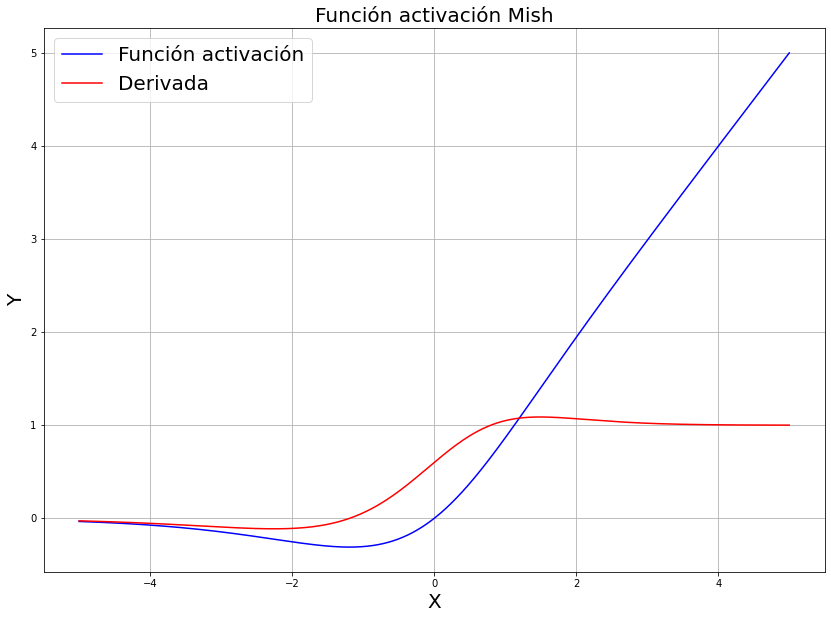

In [ ]:
def mish(x):
  return x*np.tanh(np.log(1+np.exp(x)))

def deri_mish(x):
  up = np.exp(x)*(4*(x+1) + 4*np.exp(2*x) + np.exp(3*x) + np.exp(x)*(4*x+6))
  down = 2*np.exp(x) + np.exp(2*x) + 2
  return up/(down*down)
  
plot_activation_deri(mish, deri_mish, "Función activación Mish")

# **Función ELU**

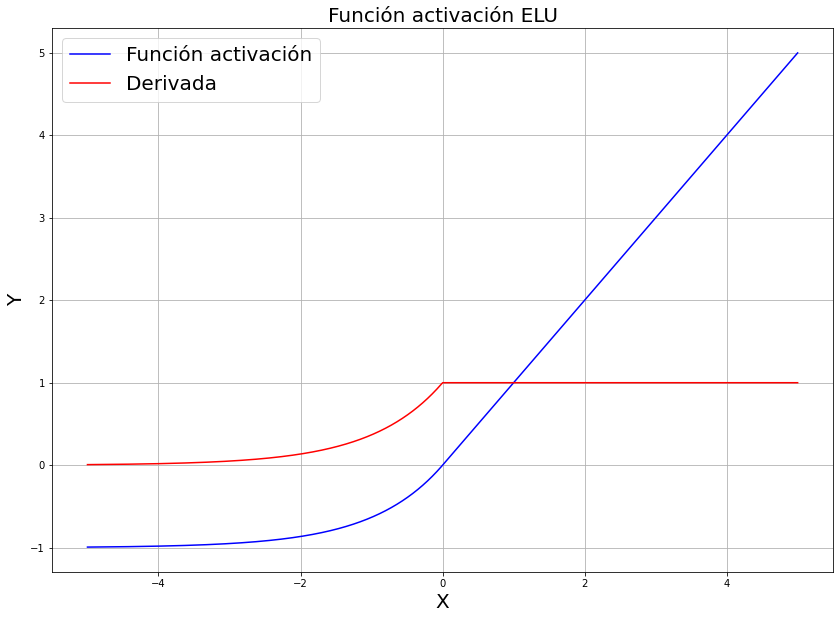

In [ ]:
def elu(x):
  return list(map(lambda x: x if x>0 else np.exp(x)-1, x))

def deri_elu(x):
  return list(map(lambda x: 1 if x>0 else np.exp(x), x))

plot_activation_deri(elu, deri_elu, "Función activación ELU")

# **Función Silu**

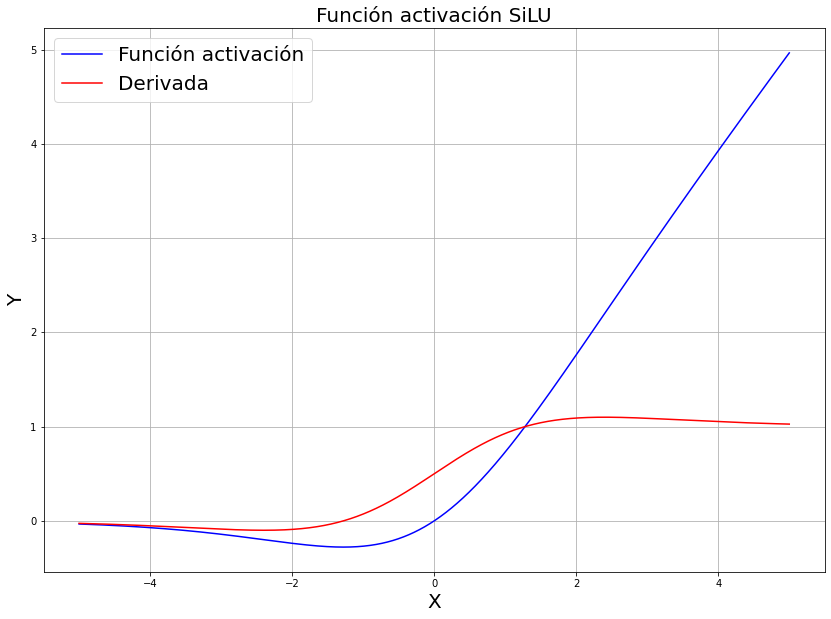

In [ ]:
def silu(x):
  return x*sigmoid(x)

def deri_silu(x):
  return sigmoid(x) + x*deri_sigmoid(x)

plot_activation_deri(silu, deri_silu, "Función activación SiLU")

### Análisis 

De los resultados obtenidos y de los gráficos mostrados, se puede concluir que:
- Sí bien los resultados son similares para todas las funciones de activación, las mayores diferencias se aprecian entre los resultados de la función Sigmoide y los resultados de las demás funciones. Lo anteriormente mencionado se puede notar observando los gráficos de las derivadas de las funciones de activación. Las derivadas de las funciones Leaky ReLU, Mish, ELU y SiLU comparten un aspecto en común: en el dominio de los números positivos, el valor de las derivadas es cercano a 1 y, en el dominio de los números negativos, el valor de las derivadas es cercano a 0.

 Sin embargo, para el caso de la función sigmoide, tanto en el dominio de los números positivos como en el dominio de los números negativos, el valor de la derivada tiende a 0. Asimismo, el máximo de la función derivada se halla cuando se tiene que $x=0$ y dicho máximo es de 0.2, muy lejano al máximo de la funciones Leaky ReLU, Mish, ELU y SiLU (máximo que es cercano a 1). 

 Dicha diferencia hace que la propagación de errores en redes con función de activación sigmoide se vea perjudicada ya que, dado que el valor máximo de la derivada es 0.2, cuando se propaga el error mediante backpropagation, el error pierde *importancia* a través
de su propagación. En cambio, para las redes donde el valor máximo es 1 y dicho valor se encuentra presente en gran parte del dominio, cuando se propaga el error mediante brackpropagation, el error no pierde relevancia y, por tanto, las redes aprenden mejor.


- Si bien los resultados son similares las mayores diferencias se pueden apreciar entre los resultados de la función Sigmoide y las demás. Esto puede ser explicado con las similitudes entre estas funciones y una gran diferencia que tienen en comparación con la función Sigmoide. Las derivadas de este grupo de funciones (Leaky ReLU, Mish, ELU, SiLU) poseen resultados cercanos a 1 para valores mayores que 0, mientras que la función sigmoide posee un valor máximo de 0.2 en el caso de x=0 y luego decae a ser cercano a 0. Esta pequeña diferencia hace que la propagación del error en redes que implementan la función sigmoide se vea perjudicada ya que esta propagación tiende a ser cero lo cual crea una red que aprende menos en cada iteración. En el caso del grupo anteriormente mencionado, los valores cercanos a 1 hacen que el error se propague de mejor manera, creando redes que aprenden mucho más.

- Respecto a la función Leaky ReLU, nótese que la derivada de dicha función no es *suave* en su trancisión entre el dominio de los números negativos y el dominio de los números positivos: a todos los números negativos les asigna un valor y a todos los números positivos les asigna otro valor. Es decir, la derivada de la función Leaky ReLU tiene la forma de una función “escalonada”. 
 
 En cambio, las funciones  Mish, ELU y SiLU, en términos generales, tienen un comportamiento similar a la función Leaky ReLU (sus derivadas son cercanas a 0 cuando x en negativo y 1 cuando x es positivo) pero son más *suaves* en sus valores a lo largo de todo su dominio.
 
  De esa forma, se puede conjeturar que las funciones Mish, ELU y SiLU obtienen mejores resultados que la función Leaky ReLU dado lo anteriormente planteado. Sin embargo, nótese que las diferencias son bastantes pequeñas así que, en este caso, el componente “escalonado” de la función Leaky ReLU no genera una gran diferencia.

### Mayores *Takeaways*

- Lo más importante a resaltar en este análisis es que funciones de activación que poseen derivadas cercanas o iguales a 1 cuando el valor de x es positivo crean mejores redes que funciones con derivadas cuyo valor en el mismo intervalo es mucho menor a 1.
 
- En el grupo de funciones de activación con derivada cercana o igual a 1 en el dominio de los números positivos (Leaky ReLU, Mish, ELU y SiLU), la mayor diferencia se encuentra en la complejidad de cálculo de dichas funciones y sus derivadas. Por ejemplo, las funciones Mish y ELU obtienen resultados muy similares, sin embargo, poseen funciones
y derivadas con complejidades de cálculo muy distintas.

 La función Mish y su derivada son las siguientes funciones:
 \begin{equation}
 f(x) = x \cdot \tanh(\ln(1+e^{x}))
\end{equation}

 \begin{equation}
 f'(x) = \frac{e^{x} ⋅ (4(x+1) + 4e^{2x} + e^{3x} + e^{x}(4x +6))}{2e^{x} + e^{2x} + 2}
\end{equation}

 En cambio, la función ELU y su derivada son las siguientes funciones:
 \begin{equation}
 f(x) = \begin{cases}
 x, & x >= 0 \\
 e^{x} - 1, & x < 0
 \end{cases}
\end{equation}

 \begin{equation}
 f'(x) = \begin{cases}
 1, & x >= 0 \\
 e^{x}, & x < 0
 \end{cases}
\end{equation}

 Nótese que la función Mish y su derivada poseen una gran cantidad de cálculos, en cambio, la función ELU posee un simple if y cálculos más simples.
 
- Los resultados obtenidos en cuanto a el accuracy de los modelos es consistente con experimentos reales. Esto se puede observar en la siguiente tabla proveniente del estudio “Mish: A Self Regularized Non-Monotonic
Activation Function“ hecho por Diganta Misra en Landskape, KIIT, Bhubaneswar, India. 


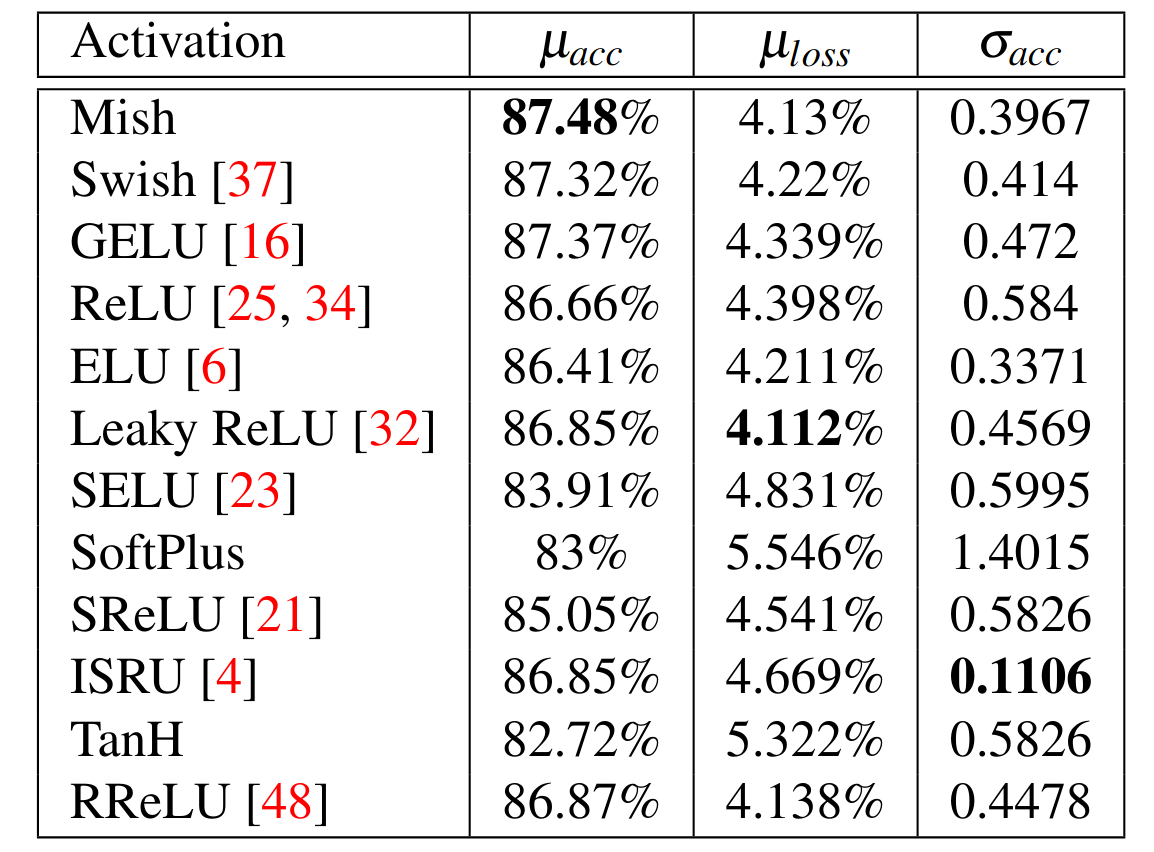